## 기존 방식(규칙 기반)의 한계점 발견
이전 시간에 논의한 '감성 사전' 방식은 간단하고 직관적이지만, 다음과 같은 명확한 한계가 있다.

- 신조어/미등록 단어: 사전에 없는 단어(예: '떡상', '떡락')는 분석할 수 없다.

- 문맥/뉘앙스 파악 불가: "전혀 나쁘지 않다"와 같은 부정문이나, "정말 대단한 삽질이었다" 같은 반어법(비꼬는 표현)의 진짜 의미를 파악하지 못한다.

> 문제의 진화: 사람이 직접 만든 규칙(사전)만으로는 복잡한 인간의 언어를 모두 처리할 수 없다.

## 머신러닝 (지도 학습)
복잡한 인간의 언어를 컴퓨터가 이해할 수 있도록 만드는 것이 바로 머신러닝, 그중에서도 **지도 학습(Supervised Learning)**이다.

### [핵심 개념]
지도 학습은 기계에게 **'정답지가 있는 문제집'**을 주고 학습시키는 것과 같다.

- 문제 (X): 뉴스 기사 본문
- 정답 (Y): 해당 기사가 '긍정'인지 '부정'인지 미리 표시된 라벨

기계는 수많은 문제와 정답 쌍을 보면서, 어떤 단어나 표현이 '긍정'적인 문장에서 자주 나타나고,<br>
어떤 것이 '부정'적인 문장에서 자주 나타나는지 그 패턴과 규칙을 스스로 학습한다.

### [머신러닝 감성 분석의 과정]

#### 1. 데이터 준비
'긍정' 또는 '부정' 라벨이 달려있는 대규모 텍스트 데이터를 준비한다. (e.g., 네이버 영화 평점 데이터)

In [ ]:
!pip install gdown -q
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 28.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import drive

# 1. 구글 드라이브를 '/content/drive' 폴더에 연결(마운트)
drive.mount('/content/drive')

# 2. '/content/drive/MyDrive/'로 시작하는 전체 경로로 수정
file_path = '/content/drive/MyDrive/수업/데이터 분석/회사 내부 강의/4일차/data/ratings.txt'
# 1: 긍정
# 2: 부정

# 3. pd.read_csv를 사용하여 탭으로 구분된 txt 파일 읽기
df = pd.read_csv(file_path, sep='\t')

# 데이터
display(df[0:-5])

Mounted at /content/drive


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199990,5465496,장르는 무협인데 내가 보기엔 코믹이던데 막장 평점 2점도 아깝다,0
199991,8965828,나치입장에서 본 영화가 갑자기 연속으로 나오네? 뭔일 있었나...,0
199992,2228930,태권도???,0
199993,417815,음 왜 봤을까? 예고편이 다 -,0


#### 2. 텍스트 벡터화:
컴퓨터가 이해하도록 텍스트를 숫자 벡터로 변환한다. (TF-IDF가 이 단계에서 사용된다.)

- A. 결측치(Null) 확인 <br>
리뷰 내용이 없거나 라벨이 없는 데이터는 모델 학습에 사용할 수 없으므로 확인하고 제거해야 한다.

In [ ]:
# 'document' 컬럼에 비어있는 값이 있는지 확인
print(df.isnull().sum())

# 결측치가 있는 행 제거
df.dropna(inplace=True)
print(f'결측치 제거 후 데이터 개수: {len(df)}개')

id          0
document    8
label       0
dtype: int64
결측치 제거 후 데이터 개수: 199992개


- B. 라벨 분포 확인 <br>
긍정(1) 리뷰와 부정(0) 리뷰가 균등하게 분포해 있는지 확인한다. <br>
데이터가 한쪽으로 치우쳐 있으면 모델이 편향되게 학습될 수 있다.

In [ ]:
# 라벨 값의 개수 확인
print(df['label'].value_counts())

label
1    99996
0    99996
Name: count, dtype: int64


### 2. 텍스트 전처리 및 분리
이제 모델이 학습할 수 있도록, 리뷰 텍스트('document' 컬럼)에서 불필요한 노이즈를 제거하고 핵심 단어만 추출한다.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer 객체 생성
# stop_words: 불용어 리스트 (필요에 따라 더 풍부하게 정의 가능)
# token_pattern: 한글/알파벳 단어만 토큰으로 사용 (구두점 제거 효과)
vectorizer = TfidfVectorizer(
    stop_words=['은', '는', '이', '가', '을', '를', '이다', '입니다', '하다', '있다', '모든', '대한', '및', '하', '습니다', '이다', '것', '점', '때문', '수', '개'],
    token_pattern=r'\b[가-힣a-z]+\b'
)

X = vectorizer.fit_transform(df["document"])
Y = df["label"]

# 생성된 행렬의 크기 확인 (문서 개수, 단어 개수)
print(f'TF-IDF 행렬 크기: {X.shape}')

TF-IDF 행렬 크기: (199992, 338651)


- B. 훈련 데이터 분리


In [ ]:
from sklearn.model_selection import train_test_split


# 훈련 세트와 테스트 세트 분리
# test_size=0.2: 전체 데이터의 20%를 테스트 세트로 사용
# random_state=42: 재현성을 위한 시드값 (동일한 결과를 얻기 위함)
# stratify=y: 레이블(y)의 클래스 비율을 훈련/테스트 세트에 동일하게 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"---  훈련/테스트 세트 분리 ---")

# 분리된 데이터의 개수 확인
print(f'훈련 데이터 개수: {X_train.shape[0]} 레이블 : {len(y_train)}')
print(f'테스트 데이터 개수: {X_test.shape[0]} 레이블 : {len(y_test)}')

---  훈련/테스트 세트 분리 ---
훈련 데이터 개수: 159993 레이블 : 159993
테스트 데이터 개수: 39999 레이블 : 39999


#### 3.  머신러닝 모델 선택 및 학습
이 단계에서는 3단계에서 준비한 '문제집'(X_train, y_train)을 가지고 머신러닝 모델을 똑똑하게 만드는, 즉 **학습(Training)**시키는 과정이다.

- 선택 알고리즘: 로지스틱 회귀 (Logistic Regression)

- 학습 과정: 모델은 훈련 데이터(수많은 리뷰 벡터와 그에 해당하는 긍정/부정 라벨)를 보면서, 어떤 단어들이 긍정적인 리뷰에, 또 어떤 단어들이 부정적인 리뷰에 주로 나타나는지에 대한 수학적인 패턴을 학습한다

<img src="https://drive.google.com/uc?id=1LS4k2y0viXtK6QhkKYHPC5_WFOcRrc2p" width=400 />

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. 로지스틱 회귀 모델 객체 생성
model = LogisticRegression(max_iter=1000) # max_iter: 모델이 최적의 답을 찾기 위해 반복하는 최대 횟수

# 2. 훈련 데이터를 사용하여 모델 학습
# .fit() 함수가 바로 '학습'을 수행하는 명령어입니다.
print("모델 학습을 시작합니다...")
model.fit(X_train, y_train)
print("모델 학습이 완료되었습니다.")

모델 학습을 시작합니다...
모델 학습이 완료되었습니다.


#### 4. 모델 평가
4단계에서 학습시킨 model을 사용하여, 3단계에서 따로 떼어놓았던 테스트 데이터(X_test)의 감성을 예측하고, 실제 정답(y_test)과 비교하여 모델의 정확도를 측정

In [ ]:
from sklearn.metrics import accuracy_score

# 1. 테스트 데이터를 사용하여 감성 예측
# .predict() 함수는 학습된 모델이 정답을 예측하는 명령어.
print("테스트 데이터로 예측을 시작합니다...")
y_pred = model.predict(X_test)
print("예측이 완료되었습니다.")

# 2. 모델의 성능(정확도) 평가
# accuracy_score() 함수는 실제 정답(y_test)과 모델의 예측(y_pred)을 비교하여 정확도를 계산.
accuracy = accuracy_score(y_test, y_pred)

print(f"\n모델의 정확도: {accuracy * 100:.2f}%")

테스트 데이터로 예측을 시작합니다...
예측이 완료되었습니다.

모델의 정확도: 81.43%


--- 분류 보고서 (Classification Report) ---
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     20000
           1       0.84      0.77      0.81     19999

    accuracy                           0.81     39999
   macro avg       0.82      0.81      0.81     39999
weighted avg       0.82      0.81      0.81     39999


--- 혼동 행렬 (Confusion Matrix) ---
[[17171  2829]
 [ 4600 15399]]


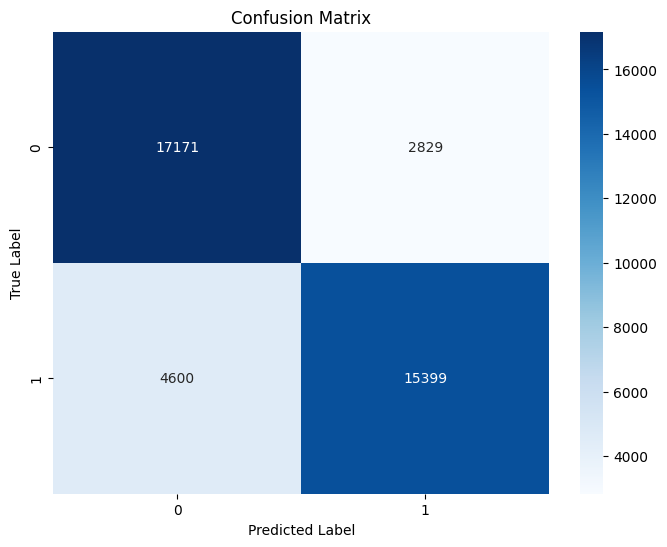

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 1. 분류 보고서 출력 (정밀도, 재현율, F1-점수 등)
# classification_report() 함수는 주요 분류 지표를 텍스트 보고서 형태로 보여준다.
print("--- 분류 보고서 (Classification Report) ---")
report = classification_report(y_test, y_pred)
print(report)

# 2. 혼동 행렬 (Confusion Matrix) 생성 및 시각화
# confusion_matrix() 함수는 모델이 어떤 클래스를 어떤 클래스로 잘못 예측했는지 보여준다.
print("\n--- 혼동 행렬 (Confusion Matrix) ---")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# 혼동 행렬을 히트맵으로 시각화하여 더 쉽게 이해할 수 있다.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Precision (정밀도) - "모델이 'Positive'라고 예측한 것 중, 실제로 'Positive'인 것의 비율" (참을 참으로 예측한 비율)
# Recall (재현율) - "실제 'Positive'인 것 중, 모델이 'Positive'라고 예측한 것의 비율" (참을 모델이 참으로 분류하지 못함)
# F1-Score - "정밀도와 재현율의 조화 평균"
# Support - "각 클래스에 속한 실제 데이터의 개수"

#### 5. 예측:


In [ ]:
import re
from konlpy.tag import Okt

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def preprocess(text):
    # 한글과 공백만 남기고 모두 제거
    cleaned_text = re.sub(r'[^가-힣 ]', '', str(text))
    # 형태소 단위로 토큰화
    tokens = okt.morphs(cleaned_text, stem=True) # stem=True: 어간 추출
    # 불용어 제거
    filtered_tokens = [token for token in tokens if not token in stopwords]
    return filtered_tokens

In [ ]:
# 새로운 리뷰 텍스트
new_reviews = [
    "이 영화 정말 재미없네요. 돈이 아까워요.",
    "인생 최고의 영화였습니다. 배우들 연기가 대박!",
    "그냥 그럭저럭 볼만 했어요."
]

# 1. 새로운 텍스트도 동일하게 전처리
cleaned_new_reviews = [' '.join(preprocess(review)) for review in new_reviews]

# 2. 전처리된 텍스트를 TF-IDF 벡터로 변환 (학습 때 사용한 vectorizer 그대로 사용)
new_reviews_vec = vectorizer.transform(cleaned_new_reviews)

# 3. 학습된 모델로 감성 예측
new_pred = model.predict(new_reviews_vec)

# 예측 결과 출력
for review, sentiment in zip(new_reviews, new_pred):
    sentiment_label = '긍정' if sentiment == 1 else '부정'
    print(f"'{review}' -> 예측: {sentiment_label}")

'이 영화 정말 재미없네요. 돈이 아까워요.' -> 예측: 부정
'인생 최고의 영화였습니다. 배우들 연기가 대박!' -> 예측: 긍정
'그냥 그럭저럭 볼만 했어요.' -> 예측: 부정
